#Initial Setup

We set up the necessary libraries we need for the assignment. These contain tools for initial exploratory analysis, working with data, and train the model.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score,
                             classification_report)


#Preliminary Steps

The preliminary steps for our data are exploring the data so we can gather some interesting insights. The work we have done below shows us notable details about the data. For example, some features like fare have too wide of a range to not think that there will be outliers. Additionally, we can infer that some of the columns will not be useful for our model. For example, the name is too general to give us any meaningful insight. If we extracted the title out of the name, then we might get some use out of it, but I think this is not a necessary step and should not be a priority in our case. The heatmap of missing values gives us an idea of what kind of data cleaning will need to be performed. Some of the columns may need to be dropped due to having too many empty values, while others can be filled according to their variable type.

Data Preview:
   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0          

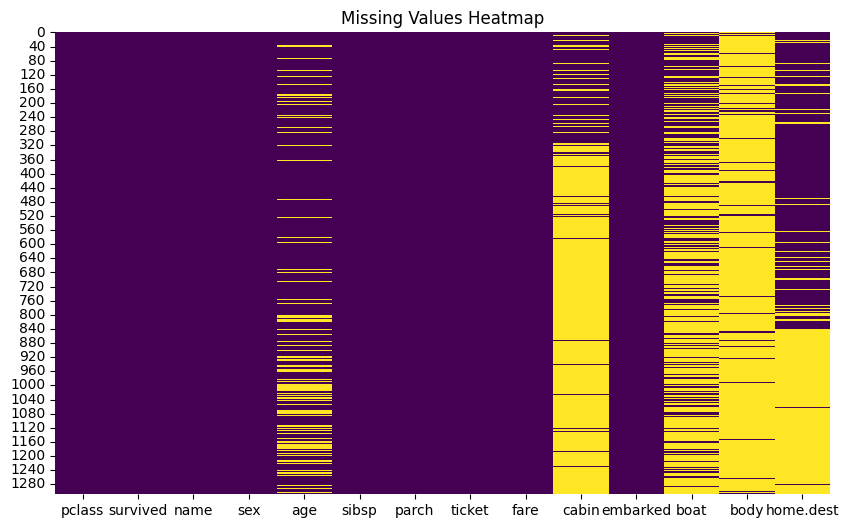

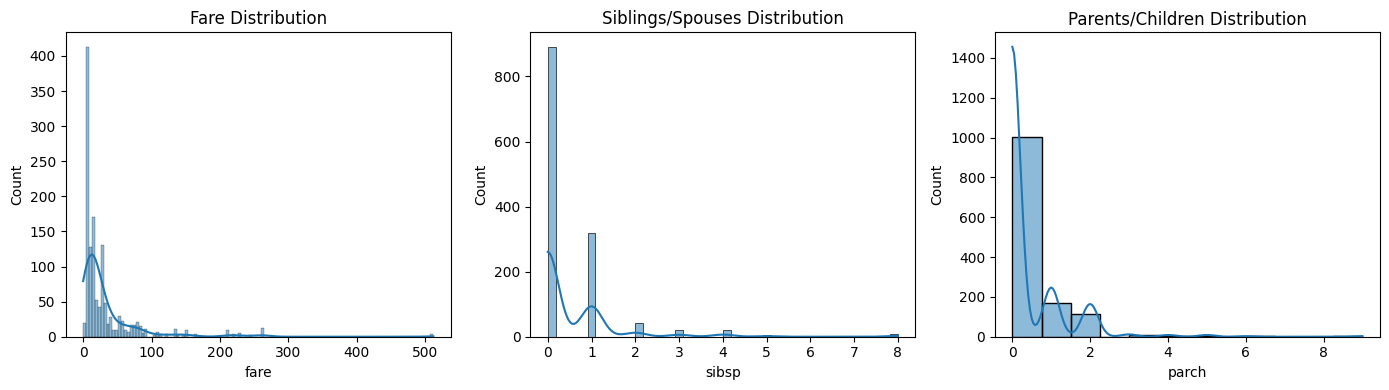

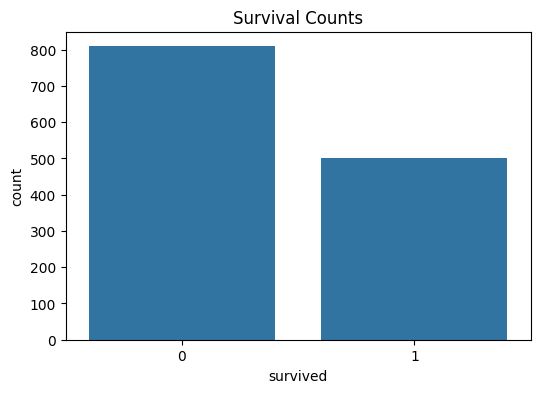

In [3]:
df = pd.read_excel("./titanic3.xls")

# Display initial preview to understand the data's structure.
print("Data Preview:")
print(df.head())

# Get info about the dataset (column types, non-null counts, etc.).
print("\nData Info:")
print(df.info())

# Show summary statistics for numerical features.
print("\nDescriptive Statistics:")
print(df.describe())

# Visualize missing values using a heatmap.
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Additional Exploratory Data Analysis (EDA)
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
sns.histplot(df['fare'], kde=True)
plt.title("Fare Distribution")

plt.subplot(1, 3, 2)
sns.histplot(df['sibsp'], kde=True)
plt.title("Siblings/Spouses Distribution")

plt.subplot(1, 3, 3)
sns.histplot(df['parch'], kde=True)
plt.title("Parents/Children Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='survived', data=df)
plt.title("Survival Counts")
plt.show()

#Cleaning the data

Here we start to clean the data and prepare it for training. We drop many columns due to different reasons. The name is mostly unique and does not offer any valuable information. The ticket is too inconsistent to gather anything meaningful. Cabin has too many empty values to fill in reliably. Boat and body are data that are only known after the incident, so we drop them to avoid leakage. The home.dest values offer no predictive significance and can safely be dropped.

In [4]:
drop_cols = ['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest']
for col in drop_cols:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

In [5]:
print("\nColumns after dropping irrelevant ones:")
print(df.columns)


Columns after dropping irrelevant ones:
Index(['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked'],
      dtype='object')


Here we start filling in the missing values. For numerical variables, we submit the median as it is resistant to outliers and can reasonably be used to fill missing values. For categorical variables, we use the mode, as this is the most common element.

In [6]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
            print(f"Inputed missing values in categorical column '{col}' with mode: {mode_value}")
        else:
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
            print(f"Inputed missing values in numerical column '{col}' with median: {median_value}")

Inputed missing values in numerical column 'age' with median: 28.0
Inputed missing values in numerical column 'fare' with median: 14.4542
Inputed missing values in categorical column 'embarked' with mode: S


<ipython-input-6-406c0dcbe149>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
<ipython-input-6-406c0dcbe149>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

One of the essential steps we need to perform is encoding categorical variables. ML algorithms require numerical data, which is not what categorical variables are. By encoding them and turning them into numerical values, we can use them to train our model. The training is performed using OneHotEncoder

In [10]:
categorical_features = []
for col in ['sex', 'embarked', 'pclass']:
    if col in df.columns:
        categorical_features.append(col)

In [11]:
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cat = one_hot_encoder.fit_transform(df[categorical_features])
encoded_cat_df = pd.DataFrame(encoded_cat,
                              columns=one_hot_encoder.get_feature_names_out(categorical_features))

In [12]:
df = df.drop(columns=categorical_features).join(encoded_cat_df)

In [13]:
numerical_features = ['fare', 'sibsp', 'parch']
scaler = StandardScaler()
for feature in numerical_features:
    if feature in df.columns:
        df[feature] = scaler.fit_transform(df[[feature]])
        print(f"Scaled feature '{feature}' using StandardScaler.")

Scaled feature 'fare' using StandardScaler.
Scaled feature 'sibsp' using StandardScaler.
Scaled feature 'parch' using StandardScaler.


#Feature Scaling and Splitting the Data

Since we have multiple different features, they all have different value ranges. This will be a problem as the algorithm will innacurately weigh these values during its training and we will have innacurate predictions. To prevent them, we standardize them so they all have the same range and don't cause problems during the training process. Additionally, at this stage the data is split into training, validation, and test datasets.

In [14]:
y = df['survived']
X = df.drop(columns=['survived'])

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [16]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_val = X_val.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

#Addressing Class Imbalances using SMOTE

Our data has a problem - the number of survivors is heavily outweighed by the number of non-survivors. This will cause our model to skew towards predicting the majority class. If we apply SMOTE, we will balance the data and the model will be better suited to detect patters in the minority class.

In [17]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("\nAfter SMOTE, the class distribution in training set:")
print(pd.Series(y_train).value_counts())


After SMOTE, the class distribution in training set:
survived
0    566
1    566
Name: count, dtype: int64


#Feature Selection

Some of the features in our data may be highly correlated. This means that one of these features can be dropped without losing predictive power, while also simplifying the model. To do this, we use the Upper Triangle method. If we find any redundant features, they are dropped

In [18]:
corr_matrix = X_train.corr().abs()

In [19]:
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

In [20]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print("\nFeatures identified for removal due to high correlation:", to_drop)


Features identified for removal due to high correlation: []


In [21]:
if len(to_drop) < X_train.shape[1]:
    X_train = X_train.drop(columns=to_drop)
    X_val = X_val.drop(columns=to_drop)
    X_test = X_test.drop(columns=to_drop)
else:
    print("Skipping feature drop to avoid empty feature set.")

#Training the Model

As we have finished the preliminary work, we can now start training the model. We will be using logistic regression. It's performance metris, like precision, recall, accuracy, ROC-AUC and the F1 score will give us an idea of how well it performs. Additionally, the confusion matrix and the classification report gives us an idea of what specific weakpoints we need to target in the pipeline.

In [22]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [23]:
y_val_pred = model.predict(X_val)

In [24]:
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
conf_matrix = confusion_matrix(y_val, y_val_pred)

In [25]:
print("\nBaseline Logistic Regression Performance on Validation Set:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))


Baseline Logistic Regression Performance on Validation Set:
Accuracy: 0.8112244897959183
Precision: 0.7375
Recall: 0.7866666666666666
F1 Score: 0.7612903225806451
ROC AUC: 0.8790082644628099
Confusion Matrix:
 [[100  21]
 [ 16  59]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84       121
           1       0.74      0.79      0.76        75

    accuracy                           0.81       196
   macro avg       0.80      0.81      0.80       196
weighted avg       0.81      0.81      0.81       196



#Improving the Model

We can use GridSearchCV for logistic regression allows us to improve our model performance. We can see that tuning parameters, regularization strength and penalty type can significantly alter the model's performance. We can try other optimization techniques to see if the linear nature of logistic regression is enough to give accurate predictions. It may be the case that our data cannot reliably be predicted using just a linear approach.

In [26]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

In [29]:
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("\nBest parameters from GridSearchCV:", grid_search.best_params_)
print("Best F1 score from GridSearchCV:", grid_search.best_score_)


Best parameters from GridSearchCV: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 score from GridSearchCV: 0.7512128085040702


In [30]:
best_lr = grid_search.best_estimator_
y_val_pred_best_lr = best_lr.predict(X_val)
print("\nTuned Logistic Regression Performance on Validation Set:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_best_lr))
print("Precision:", precision_score(y_val, y_val_pred_best_lr))
print("Recall:", recall_score(y_val, y_val_pred_best_lr))
print("F1 Score:", f1_score(y_val, y_val_pred_best_lr))
print("ROC AUC:", roc_auc_score(y_val, best_lr.predict_proba(X_val)[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_best_lr))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_best_lr))


Tuned Logistic Regression Performance on Validation Set:
Accuracy: 0.8112244897959183
Precision: 0.7375
Recall: 0.7866666666666666
F1 Score: 0.7612903225806451
ROC AUC: 0.8786776859504133
Confusion Matrix:
 [[100  21]
 [ 16  59]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84       121
           1       0.74      0.79      0.76        75

    accuracy                           0.81       196
   macro avg       0.80      0.81      0.80       196
weighted avg       0.81      0.81      0.81       196



In [31]:
final_model = best_lr
y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nFinal Test Set Accuracy:", test_accuracy)


Final Test Set Accuracy: 0.7817258883248731
